# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

First, we need to import the libraries

In [3]:
import pandas as pd
import numpy as np
import math
import json
import datetime
from ast import literal_eval

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

# Data exploration

## Portfolio file

In [4]:
portfolio.head(1)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

 We check the number of unique offers

In [7]:
portfolio.id.nunique()

10

In [8]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

We can see that we have 10 differents ids distributed in: 

* 4 bogo
* 4 discount
* 2 informational

The column of **channels** is a list, so we have to expand it get  categorical variables in the dataset.

## Profile file

In [9]:
profile.head(1)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [11]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

The number of null values in **gender** and **income** are the same

In [12]:
profile['id'].nunique()

17000

We check distribution of gender column

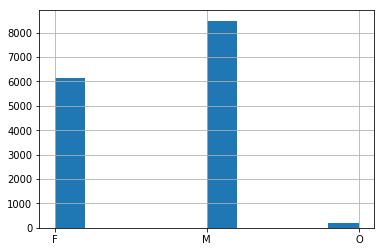

In [13]:
profile.gender.hist()

We check distribution of age column

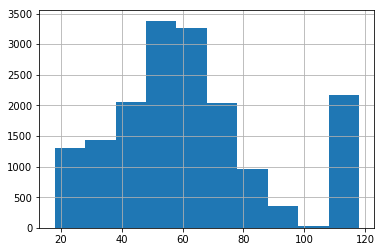

In [14]:
profile.age.hist()

We check the value of age=118

We can see the percentage of this:

In [15]:
print(profile[profile['age']==118]['age'].count() / profile.shape[0]*100, '%')

12.7941176471 %


We can see the total:

In [16]:
print(profile[profile['age']==118].count())

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


Now, we see that the 2175 is the same values of the **gender** and **income** when the value is null:

In [17]:
profile.gender.isnull().sum()

2175

In [18]:
profile.income.isnull().sum()

2175

In [19]:
profile[['gender','income','age']][profile['age']==118].head()

,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


# transcript file

In [20]:
transcript.head(1)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


In [21]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

We check the unique people:

In [23]:
transcript['person'].nunique()

17000

# Data cleaning

## Portfolio file

In [24]:
def clean_portfolio (df_portfolio):

    # We need a copy of the original df
    portfolio = df_portfolio.copy()
    
    # We need to rename 'id' to 'offer_id'
    portfolio.rename(columns={'id':'offer_id'}, inplace=True)
     
    # We need to convert the 'duration' to hours
    portfolio['duration'] = portfolio['duration'] * 24
    
    # We need to assign more readable offer ids
    #portfolio['offer_id'] = portfolio['offer_id'].map(offer_mapping)
    
    # We need to explode 'channels' and remove 'channels'
    portfolio['web'] = portfolio['channels'].astype(str).str.contains('web').astype(int)
    portfolio['email'] = portfolio['channels'].astype(str).str.contains('email').astype(int)
    portfolio['mobile'] = portfolio['channels'].astype(str).str.contains('mobile').astype(int)
    portfolio['social'] = portfolio['channels'].astype(str).str.contains('social').astype(int)
    portfolio.drop(columns='channels', inplace=True)
    
    return portfolio

In [25]:
portfolio = clean_portfolio(portfolio)

In [26]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


## Profile file

In [27]:
def clean_profile (df_profile):

    # We need a copy of the original df
    profile = df_profile.copy()
    
    # We need to rename 'id' to 'person_id'
    profile.rename(columns={'id':'person_id'}, inplace=True)
    
    # Remove null values. In oor case, customers with age 118
    age_118 = profile[profile['age'] == 118]
    profile.drop(index=age_118.index, inplace=True) 
    
    # Assign each person the corresponding pseudonym
    #profile['person_id'] = profile.apply(lambda x : id_df.loc[x.person_id], axis=1)
    
    # We need to replace 'became_member_on' with 'member_since' and set the format
    profile['member_since'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    profile['member_since'] = pd.DatetimeIndex(profile['member_since']).year
    profile.drop(columns=['became_member_on'], inplace=True)
    
    # To have an easy manage, we assig:
    
    # age ranges (10-19, 20-20, etc) 
    labels = ['10-19','20-29', '30-39', '40-49', '50-59','60-69', '70-79', '80-89', '90-99', '100-109']
    profile['age_range'] = pd.cut(profile['age'], bins=range(10,120,10), right=False, labels=labels)
    
    # income ranges (30-39, 40-49, etc)
    profile['income_range'] = pd.cut(profile['income'], bins=range(30000,140000,10000), right=False,labels=['30-39K','40-49K', '50-59K', '60-69K', '70-79K','80-89K', '90-99K','100-109K', '110-119K', '>=120K'])
    
    return profile

In [28]:
profile = clean_profile(profile)

In [29]:
profile.head(1)

,age,gender,person_id,income,member_since,age_range,income_range
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,50-59,110-119K


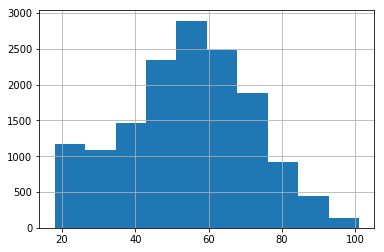

In [30]:
profile[profile['age']!=118]['age'].hist()

Mean of the age:

In [31]:
profile['age'].mean()

54.393524451939292

Mean of the income:

In [32]:
profile['income'].mean()

65404.991568296799

We can not do the mean of gender, because is a string, but we can group them by the mean of the age or income:

In [33]:
pd.DataFrame(profile.groupby(['gender']).mean()['age'])

,age
gender,
F,57.544950
M,52.116690
O,54.400943


In [34]:
pd.DataFrame(profile.groupby(['gender']).mean()['income']) 

,income
gender,
F,71306.412139
M,61194.601603
O,63287.735849


## Transcript

In [35]:
def clean_transcript (df_transcript):

    
    # We need a copy of the original df
    transcript = df_transcript.copy()
    
    # We need to rename 'id' to 'person_id'
    transcript.rename(columns={'person':'person_id'}, inplace=True)
    
    # We need to replace 'offer id' to 'offer_id' in the 'value' column
    transcript['value'] = transcript['value'].astype(str).replace({'offer id': 'offer_id'}, regex=True)
    
    # We need to convert 'value' column to actual dict
    transcript['value'] = transcript['value'].apply(literal_eval)
    
    # We need to split the 'value' column into colums ('offer_id','reward' and 'amount')
    transcript = transcript.join(pd.DataFrame(transcript.pop('value').values.tolist()))
    
    # We need to fill the NAN as a NONE 
    transcript[['offer_id', 'amount', 'reward']] = transcript[['offer_id', 'amount', 'reward']].fillna('none')
    
    # We need to replace NONE to 0
    transcript['amount'].replace('none', 0, inplace=True)
    transcript['reward'].replace('none', 0, inplace=True)
    
    # Replace 'offer_id' by the corresponding pseudonym
    #transcript['offer_id'] = transcript['offer_id'].map(offer_mapping)
    
    # Replace 'person_id' by the corresponding pseudonym
    #transcript['person_id'] = transcript.apply(lambda x : id_df.loc[x.person_id], axis=1)
    
    return transcript    

In [36]:
transcript = clean_transcript(transcript)

In [37]:
transcript.head(1)

,event,person_id,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0


# join portfolio, profile and transcript 

We need to join all the files to get the complete information. In this case we use 'merge':

In [38]:
transcript_portfolio = transcript.merge(portfolio, on='offer_id', how='left')

In [39]:
transcript_portfolio.head(1)

,event,person_id,time,amount,offer_id,reward_x,difficulty,duration,offer_type,reward_y,web,email,mobile,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,168.0,bogo,5.0,1.0,1.0,1.0,0.0


In [40]:
final_df = transcript_portfolio.merge(profile, on='person_id', how='inner')

In [41]:
final_df.head(1)

,event,person_id,time,amount,offer_id,reward_x,difficulty,duration,offer_type,reward_y,web,email,mobile,social,age,gender,income,member_since,age_range,income_range
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,168.0,bogo,5.0,1.0,1.0,1.0,0.0,75,F,100000.0,2017,70-79,100-109K


We have two columns: reward_x and reward_y. We remove reward_y and we rename the reward_x, to get one column.

In [42]:
final_df=final_df.drop(columns=['reward_y']).rename(columns={'reward_x':'reward'})

In [43]:
final_df.head(2)

,event,person_id,time,amount,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,age,gender,income,member_since,age_range,income_range
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,168.0,bogo,1.0,1.0,1.0,0.0,75,F,100000.0,2017,70-79,100-109K
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,168.0,bogo,1.0,1.0,1.0,0.0,75,F,100000.0,2017,70-79,100-109K


# Exploration

We explore the **age** of the users:

In [44]:
final_df.age.describe()

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

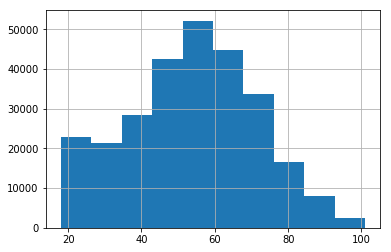

In [45]:
final_df.age.hist()

**The average age of the users is: 50-60 years**

We explore the **income** of the users:

In [46]:
final_df.income.describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

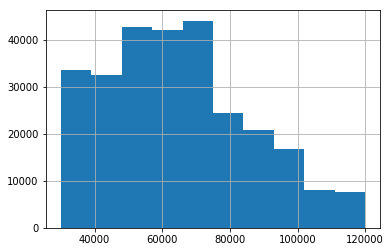

In [47]:
final_df.income.hist()

**The average of the incomes is: 60000-70000**

We explore the **gender** of the users:

In [48]:
final_df.gender.value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

We can plot it the distribution:

Text(0.5,0,'Gender')

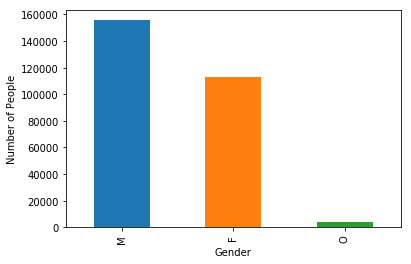

In [49]:
ax = final_df.gender.value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of People')
plt.xlabel('Gender')

We can see the percentage:

In [50]:
print(final_df.gender.value_counts()[0] / final_df.shape[0]*100, '% of Male')
print(final_df.gender.value_counts()[1] / final_df.shape[0]*100, '% of Female')
print(final_df.gender.value_counts()[2] / final_df.shape[0]*100, '% of Others or Unknow')

57.0790652657 % of Male
41.465086779 % of Female
1.45584795536 % of Others or Unknow


**Males represent more than 50%**

We explore the Offers:

In [51]:
print('offer received')
print(final_df[final_df['event'] == 'offer received'].offer_type.value_counts())
print('offer viewed')
print(final_df[final_df['event'] == 'offer viewed'].offer_type.value_counts())
print('offer completed')
print(final_df[final_df['event'] == 'offer completed'].offer_type.value_counts())

offer received
discount         26664
bogo             26537
informational    13300
Name: offer_type, dtype: int64
offer viewed
bogo             22039
discount         18461
informational     9360
Name: offer_type, dtype: int64
offer completed
discount    17186
bogo        15258
Name: offer_type, dtype: int64


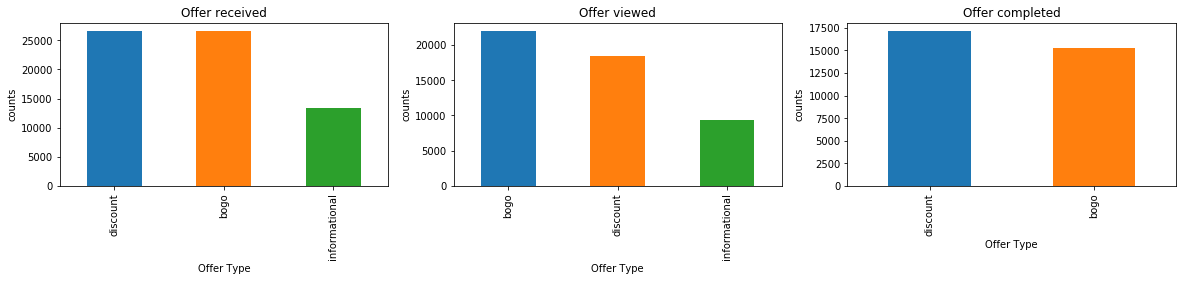

In [52]:
plt.subplot(131)
offer_received = final_df[final_df['event'] == 'offer received'].offer_type.value_counts()
offer_received.plot(kind='bar', figsize=(20,3))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received');

plt.subplot(132)
offer_viewed = final_df[final_df['event'] == 'offer viewed'].offer_type.value_counts()
offer_viewed.plot(kind='bar' , figsize=(20,3))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer viewed');

plt.subplot(133)
offer_completed = final_df[final_df['event'] == 'offer completed'].offer_type.value_counts()
offer_completed.plot(kind='bar' , figsize=(20,3))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer completed');

In [53]:
offer_received = final_df[final_df['event'] == 'offer received'].offer_type.value_counts()
offer_viewed = final_df[final_df['event'] == 'offer viewed'].offer_type.value_counts()
offer_completed = final_df[final_df['event'] == 'offer completed'].offer_type.value_counts()

**BOGO**

In [54]:
print('offer_received = ', offer_received[1])
print('offer_viewed = ', offer_viewed[0])
print('offer_completed = ', offer_completed[0])
print('--------------------')
print('offer_viewed / offer_received = ', (offer_viewed[0] / offer_received[1])*100 ,'%')
print('offer_completed / offer_received = ', (offer_completed[1] / offer_received[1])*100 ,'%')

offer_received =  26537
offer_viewed =  22039
offer_completed =  17186
--------------------
offer_viewed / offer_received =  83.050081019 %
offer_completed / offer_received =  57.4970795493 %


In [55]:
received = offer_received[1] 
viewed = offer_viewed[0] 
completed = offer_completed[1] 

viewed_perc = viewed/received
completed_perc = completed/received
received , viewed , completed , viewed_perc , completed_perc

(26537, 22039, 15258, 0.83050081018954669, 0.57497079549308516)

**DISCOUNT**

In [56]:
print('offer_received = ', offer_received[0])
print('offer_viewed = ', offer_viewed[1])
print('offer_completed = ', offer_completed[0])
print('--------------------')
print('offer_viewed / offer_received = ', (offer_viewed[1] / offer_received[0])*100 ,'%')
print('offer_completed / offer_received = ', (offer_completed[0] / offer_received[0])*100 ,'%')

offer_received =  26664
offer_viewed =  18461
offer_completed =  17186
--------------------
offer_viewed / offer_received =  69.2356735674 %
offer_completed / offer_received =  64.4539453945 %


In [57]:
received = offer_received[0] 
viewed = offer_viewed[1] 
completed = offer_completed[0] 

viewed_perc = viewed/received
completed_perc = completed/received
received , viewed , completed , viewed_perc , completed_perc

(26664, 18461, 17186, 0.69235673567356737, 0.64453945394539458)

To sum up: 
    
* Percentage of BOGO Offer viewer is 83%
* Percentage of DISCOUNT Offer viewer is 70%

We can check the offer_received, offer_viewed and offer_completed per offer_id

In [58]:
offer_received = final_df[final_df['event'] == 'offer received'].offer_id.value_counts()
offer_viewed = final_df[final_df['event'] == 'offer viewed'].offer_id.value_counts()
offer_completed = final_df[final_df['event'] == 'offer completed'].offer_id.value_counts()

In [59]:
offer_received

0b1e1539f2cc45b7b9fa7c272da2e1d7    6726
9b98b8c7a33c4b65b9aebfe6a799e6d9    6685
ae264e3637204a6fb9bb56bc8210ddfd    6683
3f207df678b143eea3cee63160fa8bed    6657
2298d6c36e964ae4a3e7e9706d1fb8c2    6655
fafdcd668e3743c1bb461111dcafc2a4    6652
5a8bc65990b245e5a138643cd4eb9837    6643
2906b810c7d4411798c6938adc9daaa5    6631
4d5c57ea9a6940dd891ad53e9dbe8da0    6593
f19421c1d4aa40978ebb69ca19b0e20d    6576
Name: offer_id, dtype: int64

In [60]:
offer_viewed

fafdcd668e3743c1bb461111dcafc2a4    6407
2298d6c36e964ae4a3e7e9706d1fb8c2    6379
4d5c57ea9a6940dd891ad53e9dbe8da0    6329
f19421c1d4aa40978ebb69ca19b0e20d    6310
ae264e3637204a6fb9bb56bc8210ddfd    5901
5a8bc65990b245e5a138643cd4eb9837    5873
9b98b8c7a33c4b65b9aebfe6a799e6d9    3499
3f207df678b143eea3cee63160fa8bed    3487
2906b810c7d4411798c6938adc9daaa5    3460
0b1e1539f2cc45b7b9fa7c272da2e1d7    2215
Name: offer_id, dtype: int64

In [61]:
offer_completed

fafdcd668e3743c1bb461111dcafc2a4    5003
2298d6c36e964ae4a3e7e9706d1fb8c2    4886
9b98b8c7a33c4b65b9aebfe6a799e6d9    4188
f19421c1d4aa40978ebb69ca19b0e20d    4103
2906b810c7d4411798c6938adc9daaa5    3911
ae264e3637204a6fb9bb56bc8210ddfd    3657
0b1e1539f2cc45b7b9fa7c272da2e1d7    3386
4d5c57ea9a6940dd891ad53e9dbe8da0    3310
Name: offer_id, dtype: int64

We plot it to have a better visualization

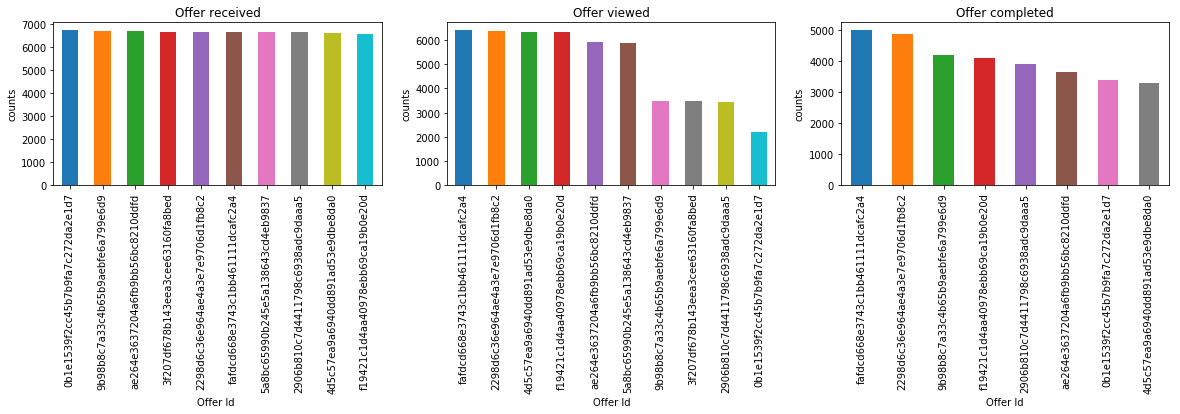

In [62]:
plt.subplot(131)
offer_received 
offer_received.plot(kind='bar', figsize=(20,3))
plt.ylabel('counts')
plt.xlabel('Offer Id ')
plt.title('Offer received');

plt.subplot(132)
offer_viewed 
offer_viewed.plot(kind='bar' , figsize=(20,3))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer viewed');

plt.subplot(133)
offer_completed 
offer_completed.plot(kind='bar' , figsize=(20,3))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer completed');

We can see that 
* **offer received:** each Offer_id have the same number of offer received
* **offer viewed:** the ratio decreased for some offer_ids
* **Offer completed:** the ratio decreased for some offer_ids

We check the **offer type per user:**

**bogo offer_received per user:**

In [63]:
final_df[final_df['offer_type']=='bogo'].groupby('person_id')['event'].count()

person_id
0009655768c64bdeb2e877511632db8f     3
0011e0d4e6b944f998e987f904e8c1e5     3
0020c2b971eb4e9188eac86d93036a77     4
0020ccbbb6d84e358d3414a3ff76cffd     6
004b041fbfe44859945daa2c7f79ee64     3
004c5799adbf42868b9cff0396190900     8
005500a7188546ff8a767329a2f7c76a     8
0056df74b63b4298809f0b375a304cf4     3
00715b6e55c3431cb56ff7307eb19675     5
0082fd87c18f45f2be70dbcbb0fb8aad     5
00840a2ca5d2408e982d56544dc14ffd     2
00857b24b13f4fe0ad17b605f00357f5     7
008d7088107b468893889da0ede0df5c     6
0091d2b6a5ea4defaa8393e4e816db60    11
0099bf30e4cb4265875266eb3eb25eab     2
00a794f62b9a48beb58f8f6c02c2f1a6     5
00ae03011f9f49b8a4b3e6d416678b0b     5
00aee28bbb3848dd8a31f0c91dc267dd     4
00b18b535d6d4f779dea4dc9ac451478     2
00b3400e4ff64ee68ce9ada1d0c222f0     2
00b3c376db2a4115af3aef34a02f61d6     6
00b901d68f8f4fd68075184cd0f772d2     6
00bbce6533f44ddeaf4dd32bcab55441     3
00bc42a62f884b41a13cc595856cf7c3     3
00bc983061d3471e8c8e74d31b7c8b6f     4
00c20a9202d5475

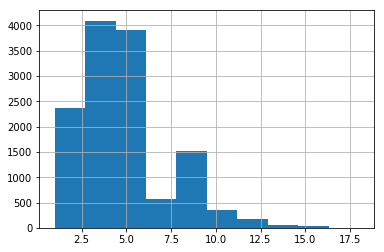

In [64]:
final_df[final_df['offer_type']=='bogo'].groupby('person_id')['event'].count().hist()

**Informational offer_received per user:**

In [65]:
final_df[final_df['offer_type']=='informational'].groupby('person_id')['event'].count()

person_id
0009655768c64bdeb2e877511632db8f    4
0011e0d4e6b944f998e987f904e8c1e5    4
0020c2b971eb4e9188eac86d93036a77    2
0020ccbbb6d84e358d3414a3ff76cffd    2
003d66b6608740288d6cc97a6903f4f0    4
00426fe3ffde4c6b9cb9ad6d077a13ea    2
004b041fbfe44859945daa2c7f79ee64    1
0056df74b63b4298809f0b375a304cf4    2
00715b6e55c3431cb56ff7307eb19675    1
0082fd87c18f45f2be70dbcbb0fb8aad    6
00840a2ca5d2408e982d56544dc14ffd    1
008d7088107b468893889da0ede0df5c    4
00a794f62b9a48beb58f8f6c02c2f1a6    6
00ae03011f9f49b8a4b3e6d416678b0b    2
00b18b535d6d4f779dea4dc9ac451478    2
00b3400e4ff64ee68ce9ada1d0c222f0    3
00bbce6533f44ddeaf4dd32bcab55441    2
00c5a385c71a4d3db5e9b4e31e430943    2
00c6035df45840038a72766c6d27a0db    2
00c91f31f5f74e769fa7a359b63e1a9f    3
00d6dc87be4146ceb47fcd4baaaf6477    1
00d791e20c564add8056498e40eb56cc    2
00d91c5919514448bc4f718e4e3f26ab    2
00e52682848542c3a6f59b7824e9a5c5    2
00e8d701c583461e81cc10053681a12b    2
00e9f403afa641889cd034ee7c7ca6e9    4
00

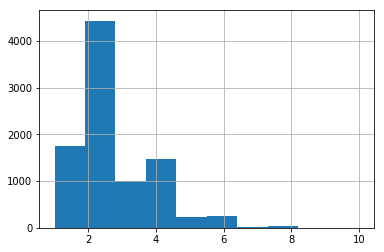

In [66]:
final_df[final_df['offer_type']=='informational'].groupby('person_id')['event'].count().hist()

**Discount offer_received per user:**

In [67]:
final_df[final_df['offer_type']=='discount'].groupby('person_id')['event'].count()

person_id
0009655768c64bdeb2e877511632db8f     5
0011e0d4e6b944f998e987f904e8c1e5     6
0020c2b971eb4e9188eac86d93036a77     5
0020ccbbb6d84e358d3414a3ff76cffd     3
003d66b6608740288d6cc97a6903f4f0     8
00426fe3ffde4c6b9cb9ad6d077a13ea     6
004b041fbfe44859945daa2c7f79ee64     3
004c5799adbf42868b9cff0396190900     6
005500a7188546ff8a767329a2f7c76a     1
0056df74b63b4298809f0b375a304cf4     5
00715b6e55c3431cb56ff7307eb19675     8
00840a2ca5d2408e982d56544dc14ffd     8
00857b24b13f4fe0ad17b605f00357f5     1
008d7088107b468893889da0ede0df5c     1
0091d2b6a5ea4defaa8393e4e816db60     3
0099bf30e4cb4265875266eb3eb25eab     8
00ae03011f9f49b8a4b3e6d416678b0b     8
00aee28bbb3848dd8a31f0c91dc267dd     1
00b18b535d6d4f779dea4dc9ac451478     9
00b3400e4ff64ee68ce9ada1d0c222f0     5
00b3c376db2a4115af3aef34a02f61d6     2
00b901d68f8f4fd68075184cd0f772d2     2
00bbce6533f44ddeaf4dd32bcab55441     6
00bc42a62f884b41a13cc595856cf7c3    11
00bc983061d3471e8c8e74d31b7c8b6f     3
00c20a9202d5475

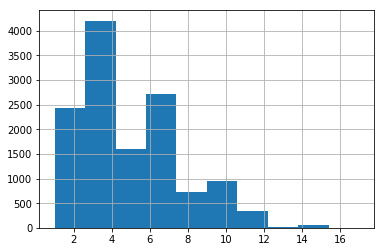

In [68]:
final_df[final_df['offer_type']=='discount'].groupby('person_id')['event'].count().hist()

# PREDICTION

We apply one-hot encode:

**GENDER**

In [69]:
genders = {'O': 0, 'M': 1, 'F': 2}

In [70]:
final_df['gender'] = final_df['gender'].map(genders)

**OFFER TYPE**

In [71]:
final_df.offer_type.value_counts()

bogo             63834
discount         62311
informational    22660
Name: offer_type, dtype: int64

In [72]:
offers = {'bogo': 0, 'discount': 1, 'informational': 2}

In [73]:
final_df['offer_type'] = final_df['offer_type'].map(offers)

In [74]:
final_df.head(1)

,event,person_id,time,amount,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,age,gender,income,member_since,age_range,income_range
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,168.0,0.0,1.0,1.0,1.0,0.0,75,2,100000.0,2017,70-79,100-109K


We need to drop the colums that we don´t need for the model:

In [75]:
final_df.columns

Index(['event', 'person_id', 'time', 'amount', 'offer_id', 'reward',
       'difficulty', 'duration', 'offer_type', 'web', 'email', 'mobile',
       'social', 'age', 'gender', 'income', 'member_since', 'age_range',
       'income_range'],
      dtype='object')

We need to apply an id to the event:

In [76]:
event_id = final_df['event'].unique()
event_id

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [77]:
event_dictionary = pd.Series(event_id).to_dict()
event_dictionary

{0: 'offer received',
 1: 'offer viewed',
 2: 'transaction',
 3: 'offer completed'}

In [78]:
event_dictionary = dict([(value, key) for key, value in event_dictionary.items()]) 
event_dictionary

{'offer received': 0,
 'offer viewed': 1,
 'transaction': 2,
 'offer completed': 3}

In [79]:
final_df['event_id'] = final_df['event'].map(event_dictionary)

In [80]:
final_df

,event,person_id,time,amount,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,age,gender,income,member_since,age_range,income_range,event_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,168.0,0.0,1.0,1.0,1.0,0.0,75,2,100000.0,2017,70-79,100-109K,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,168.0,0.0,1.0,1.0,1.0,0.0,75,2,100000.0,2017,70-79,100-109K,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,none,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2,100000.0,2017,70-79,100-109K,2
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,168.0,0.0,1.0,1.0,1.0,0.0,75,2,100000.0,2017,70-79,100-109K,3
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,none,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2,100000.0,2017,70-79,100-109K,2
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,72.0,2.0,0.0,1.0,1.0,1.0,75,2,100000.0,2017,70-79,100-109K,0
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,72.0,2.0,0.0,1.0,1.0,1.0,75,2,100000.0,2017,70-79,100-109K,1
7,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,19.67,none,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2,100000.0,2017,70-79,100-109K,2
8,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,29.72,none,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2,100000.0,2017,70-79,100-109K,2
9,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,23.93,none,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2,100000.0,2017,70-79,100-109K,2


We have to map the offer_id 

In [111]:
offer_id = final_df['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', 'none',
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5',
       '3f207df678b143eea3cee63160fa8bed',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '4d5c57ea9a6940dd891ad53e9dbe8da0'], dtype=object)

In [112]:
offer_dict = pd.Series(offer_id ).to_dict()
offer_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: 'none',
 2: '5a8bc65990b245e5a138643cd4eb9837',
 3: 'ae264e3637204a6fb9bb56bc8210ddfd',
 4: 'f19421c1d4aa40978ebb69ca19b0e20d',
 5: '2906b810c7d4411798c6938adc9daaa5',
 6: '3f207df678b143eea3cee63160fa8bed',
 7: 'fafdcd668e3743c1bb461111dcafc2a4',
 8: '2298d6c36e964ae4a3e7e9706d1fb8c2',
 9: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 10: '4d5c57ea9a6940dd891ad53e9dbe8da0'}

In [113]:
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 'none': 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '2906b810c7d4411798c6938adc9daaa5': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 8,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 9,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 10}

In [114]:
final_df['offer_id'] = final_df['offer_id'].map(offer_dict)
final_df.head()

,event,person_id,time,amount,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,age,gender,income,member_since,age_range,income_range,event_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.00,0,0.0,5.0,168.0,0.0,1.0,1.0,1.0,0.0,75,2,100000.0,2017,70-79,100-109K,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.00,0,0.0,5.0,168.0,0.0,1.0,1.0,1.0,0.0,75,2,100000.0,2017,70-79,100-109K,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2,100000.0,2017,70-79,100-109K,2
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,0.00,0,5.0,5.0,168.0,0.0,1.0,1.0,1.0,0.0,75,2,100000.0,2017,70-79,100-109K,3
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,2,100000.0,2017,70-79,100-109K,2


In [81]:
X = final_df.drop(['event_id','person_id'], axis=1)
Y = final_df['event_id']

In [82]:
X.head(1)

,event,time,amount,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,age,gender,income,member_since,age_range,income_range
0,offer received,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,168.0,0.0,1.0,1.0,1.0,0.0,75,2,100000.0,2017,70-79,100-109K


In [83]:
Y.head()

0    0
1    1
2    2
3    3
4    2
Name: event_id, dtype: int64

The shape is:

In [84]:
X.shape , Y.shape

((272762, 18), (272762,))

# Scaling: normalization and standardization

In [85]:
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import layers
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


We define the name of the class. In thus case, the event:

In [86]:
name_of_class =['offer recieved', 'offer viewed', 'offer completed','transaction']

We need to dividethe data in test and train:

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=40)

In [88]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((218209, 18), (54553, 18), (218209,), (54553,))

**Standard**

In [89]:
std = StandardScaler()

In [90]:
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [91]:
X_test.income = std.transform(X_test.income.values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test.age.values.reshape(-1, 1))

X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [92]:
X_train.shape, X_test.shape

((218209, 18), (54553, 18))

After that, we need to converto into np array to do a model:

In [93]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# MODEL

In [94]:
model = keras.models.Sequential()

We increment via the add() method:

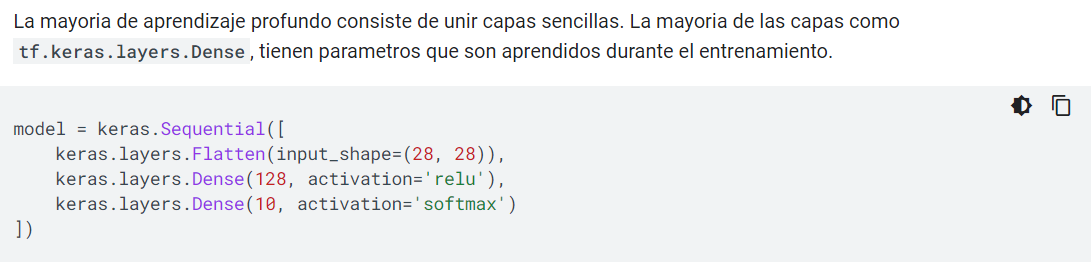

In [134]:
model.add(keras.layers.Dense(6,input_dim=7, kernel_initializer = 'normal',activation='relu'))
model.add(keras.layers.Dense(6,activation='relu'))
model.add(keras.layers.Dense(4,activation='softmax'))

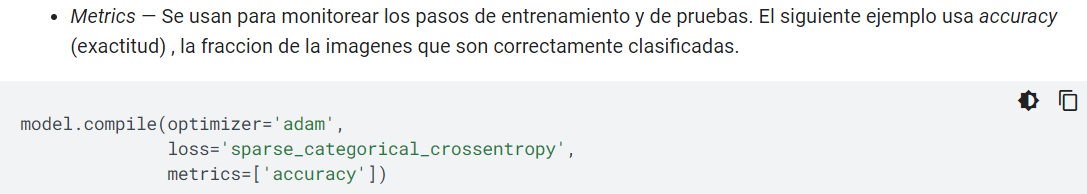

In [135]:
model.compile(loss = 'sparse_categorical_crossentropy', 
            optimizer = 'adam',
            metrics = ['accuracy'])

In [136]:
model_hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100)

Train on 190933 samples, validate on 81829 samples
Epoch 1/15
190933/190933 [==============================] - 15s 78us/step - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 2/15
190933/190933 [==============================] - 15s 77us/step - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 3/15
190933/190933 [==============================] - 13s 67us/step - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 4/15
190933/190933 [==============================] - 16s 85us/step - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 5/15
190933/190933 [==============================] - 14s 76us/step - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 6/15
190933/190933 [==============================] - 16s 84us/step - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 7/15
190933/190933 [==============================] - 15s 78us/step - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448s: nan - ETA

In [137]:
model.summary()       

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 15)                495       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 66        
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 30        
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 42        
__________

In [138]:
model_hist.params

{'batch_size': 100,
 'epochs': 15,
 'steps': None,
 'samples': 190933,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

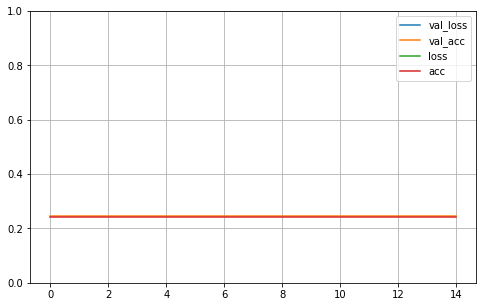

In [139]:
pd.DataFrame(model_hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# MATRIX EVALUATION

In [140]:
model.evaluate(X_test , y_test)

81829/81829 [==============================] - 5s 57us/step


[nan, 0.2448154077419889]

Conclusion

the test accuracy is 24.4% and the rate keep constant during the process. We can do some improvement:

# IMPROVE THE MODEL

New dataframe with highly recommended features and dependent features, more layers and hidden units

In [115]:
final_df.columns

Index(['event', 'person_id', 'time', 'amount', 'offer_id', 'reward',
       'difficulty', 'duration', 'offer_type', 'web', 'email', 'mobile',
       'social', 'age', 'gender', 'income', 'member_since', 'age_range',
       'income_range', 'event_id'],
      dtype='object')

In [116]:
X = final_df.drop(['event_id' ,  'amount','event' , 'email', 'mobile', 'social', 'web', 'time','duration','person_id','member_since','age_range','income_range'], axis=1)
Y = final_df['event_id']

In [117]:
X.head()

,offer_id,reward,difficulty,offer_type,age,gender,income
0,0,0.0,5.0,0.0,75,2,100000.0
1,0,0.0,5.0,0.0,75,2,100000.0
2,1,0.0,NaN,NaN,75,2,100000.0
3,0,5.0,5.0,0.0,75,2,100000.0
4,1,0.0,NaN,NaN,75,2,100000.0


In [118]:
X.shape , Y.shape

((272762, 7), (272762,))

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [120]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((190933, 7), (81829, 7), (190933,), (81829,))

In [121]:
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [122]:
X_test.income = std.transform(X_test.income.values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test.age.values.reshape(-1, 1))

X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [123]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [124]:
# MODEL

In [125]:
model = keras.models.Sequential()

In [126]:
model.add(keras.layers.Dense(32, input_dim=7, kernel_initializer = 'normal' ,activation='relu'))
model.add(keras.layers.Dense(15, kernel_initializer = 'normal' ,activation='relu'))
model.add(keras.layers.Dense(10, kernel_initializer = 'normal' ,activation='relu'))
model.add(keras.layers.Dense(6, kernel_initializer = 'normal' ,activation='relu'))
model.add(keras.layers.Dense(4, kernel_initializer = 'normal' ,activation = 'softmax'))

In [127]:
model.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

In [128]:
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100 , verbose = 2)

Train on 190933 samples, validate on 81829 samples
Epoch 1/15
 - 9s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 2/15
 - 8s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 3/15
 - 8s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 4/15
 - 8s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 5/15
 - 9s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 6/15
 - 8s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 7/15
 - 8s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 8/15
 - 8s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 9/15
 - 8s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 10/15
 - 8s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 11/15
 - 9s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 12/15
 - 9s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 13/15
 - 8s - lo

In [129]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 15)                495       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 66        
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 28        
Total params: 1,005
Trainable params: 1,005
Non-trainable params: 0
_________________________________________________________________


In [130]:
model_history.params

{'batch_size': 100,
 'epochs': 15,
 'steps': None,
 'samples': 190933,
 'verbose': 2,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

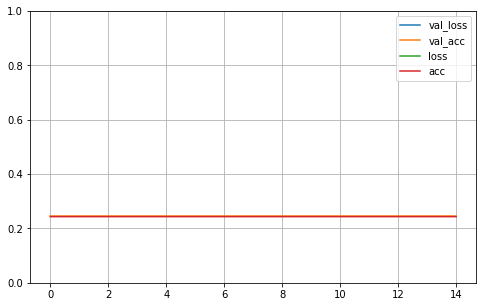

In [133]:
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# MATRIX EVALUATION

In [132]:
model.evaluate(X_test , y_test)

81829/81829 [==============================] - 4s 52us/step


[nan, 0.2448154077419889]

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Starbucks_Capstone_notebook.ipynb'])

# CONCLUSION

The most occuring event is 'offer_received', so I tried to do a model with that, but the results of the model seems like not so good. 

There is no change in rate of accuracy it keep constant.

Major classes perform well but not minorities classes. This is because an imbalance dataset.

**Potential improvement**: Design, analysis and build deep learning model